In [1]:
import numpy as np
from solver.value_iteration import VITrainer
import matplotlib.pyplot as plt
from scipy import stats

from mdps.whited import cMDPWhited
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [2]:
def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPWhited(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:, :], gt_act_arr_, gt_rew_arr_

In [3]:
c = {"context_distribution":
     ConstantDistribution(dim=5, constant_vector=np.array(
         [0.98, 0.15, 0.7, 0.7, 0.15]))
     }
c_trainer = {'grid_nums':
             np.array([5, 5])
             }
c_sim = {"context_distribution":
         ConstantDistribution(dim=5, constant_vector=np.array(
             [0.98, 0.15, 0.7, 0.7, 0.15]))
         }
c_trainer_sim = {'grid_nums':
                 np.array([20, 10])
                 }
solver_vi = VITrainer(env=cMDPWhited(config=c),
                      config=c_trainer_sim)
print("train solver")
solver_vi.train()

train solver


### For $\rho$

In [4]:
def filter_context(context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_,
                   c_trainer_
                   ):
    state_arr_ = np.ones((N_, 2))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_-1):
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                        ConstantDistribution(dim=5,
                                             constant_vector=context_)
                        }
            env_ = cMDPWhited(config=c_local_)
            solver_ = VITrainer(env=env_,
                                config=c_trainer_)
            solver_.train()
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate(
                    (np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood_rho(gt_obs_arr_[t_], action_arr_[
                                n_], gt_obs_arr_[t_+1], reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
            if n_ % 100 == 0:
                print("%s %s" % ("particle", n_))
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(
                p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(
                loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.1
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(
                context_distribution_.particles, 0.0, 1.0)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
            print("%s %s %s %s" % ("round", t_, "posterior mean",
                         context_distribution_.particles[:, 3].mean()))
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_


In [5]:
N = 500
T = 50
which_param = 3

print("simulate trajectory")
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(solver_vi, config=c_sim)

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
# theta = np.random.uniform(0.4, 0.8, size=(N,))
theta = np.ones((N,)) * 0.7
# rho = np.ones((N,)) * 0.7
rho = np.random.uniform(0.4, 0.8, size=(N,))
sigma = np.ones((N,)) * 0.15
# sigma = np.random.uniform(0.05, 0.5, size=(N,))

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(
    dim=5, particles=context_particles, n_particles=N)

simulate trajectory


In [7]:
gt_obs_arr.shape

(100, 7)

In [8]:
T=50
print("begin estimation")
context_history_vi, _ = filter_context(context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N,
                                       c_trainer
                                       )
context = context_history_vi[-1][:, which_param]

begin estimation
particle 0
particle 100
particle 200
particle 300
particle 400
particle 0
particle 100
particle 200
particle 300
particle 400
round 1 posterior mean 0.6250099117962252
particle 0
particle 100
particle 200
particle 300
particle 400
round 2 posterior mean 0.6272762326274901
particle 0
particle 100
particle 200
particle 300
particle 400
round 3 posterior mean 0.6277172212844799
particle 0
particle 100
particle 200
particle 300
particle 400
round 4 posterior mean 0.6296440014298803
particle 0
particle 100
particle 200
particle 300
particle 400
round 5 posterior mean 0.6328160582245114
particle 0
particle 100
particle 200
particle 300
particle 400
round 6 posterior mean 0.6363770930586576
particle 0
particle 100


KeyboardInterrupt: 

In [9]:
context

NameError: name 'context' is not defined

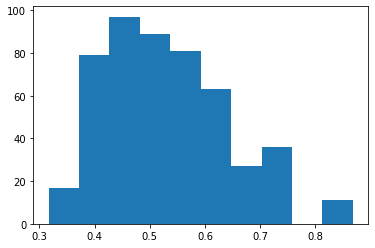

In [8]:
plt.hist(context)
plt.show()

------

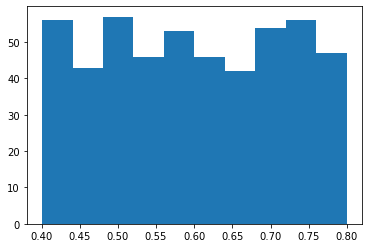

In [9]:
plt.hist(rho)
plt.show()